# Introduction 

This notebook is dedicated to implement some algorithms of the paper in those following situations :
    - Basic implementation for the basic image
    - Implementation in the situation of occlusion
    - Implementation in the situation of noisy image
    - Implementation for feature reduction
The goal of this notebook is to show the classification of ONE image in the previous situations. For the performance of the algorithms for all images please refer to the other notebook performance_on_yale.

To use this notebook you must choose at the beginning in which situation you wan't to be.

All the image comes from the dataset Extended Yale B

All the data are in : data/CroppedYale/

** Please note that you executed

In [1]:
dev_mode = 0

# Imports 

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time
import random

In [4]:
random.seed(2017) # For reproductibility

# Useful functions

The following function is the indicator function of the i-th class. For a given vector it returns just the index corresponding to the i-th class

In [5]:
def delta(x,i,classs):
    '''
    fonction indicatrice de la classe i
    '''
    n,m = len(x),len(classs)
    
    if (n != m):
        print('vectors of differents sizes, cannot operate delta')
        
    tmp = i*np.ones(n)-classs

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

The residu function returns the class which minimizes the reconstruction error following the norm 2

In [6]:
def residu(y,A,x,class_x):
    '''
    renvoie les residus pour chaque classe.
    '''
    k = np.max(class_x)+1
    r = np.zeros(k)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

Définition de la fonction retournant l'indice de concentration (_Sparsity Concentration Index_)

The SCI function implements the Sparsity Concentration Index (with $k$ number of classes and $\delta_{i}$ the indicator of i-th class)  :

$$SCI(x)=\frac{k*\mbox{max}_i  \frac{\|\delta_{i}(x)\|_{1}}{\|x\|_{1}}-1}{k-1}$$

In [7]:
def SCI(x,classs):
    '''
    @input
      - classs: classe de chaque training element.
      - x     : sparse coefficients
    '''
    
    k = len(set(classs)) # Nombre de classes différentes
    
    # Puis on retourne la valeur du SCI
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,classs),ord=1) for i in range(k)]) - 1)/(k-1)
    

**Utilitaire** : trouver la classe d'un élément du test set pour le Yale Database

In [8]:
def find_class(i):
    return int(i)/12

**Utilitaire** : The following function is dedicated to read all the images given a path to a database

In [9]:
def read_images(path, sz=None,sz0=168,sz1=192): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given) and check that it's the good size
                    if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                        if (sz is not None):
                            im = im.resize(sz, Image.NEAREST)     
                        X.append(np.asarray(im, dtype=np.uint8)) 
                        y.append(c)
                except IOError:
                    pass
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
            
    print("Images chargees !")
    return [X,y]

The following function add noise to an image. Given a amount of pixel to corrupt, it replace the pixel with a random pixel between 0 and 256.

In [10]:
def noise_image(image_input, per=0.5):
    '''
    Ajoute du bruit aléatoire à une image.
    @params:
        per : pourcentage de pixels à corrompre
    '''
    sz0 = image_input.shape[0]
    sz1 = image_input.shape[1]
    
    # Création du masque
    nb_pix_to_noise = int(np.floor(per*sz0*sz1))
    print(nb_pix_to_noise)
    
    mask = np.ones((sz0*sz1,1))
    ids = np.random.permutation(sz0*sz1)[0:nb_pix_to_noise]
    mask[ids] = 0
    mask = np.reshape(mask,(sz0,sz1))
    
    # Matrice de pixels aléatoires (intensité entre 0 et 255)
    rand_pix = np.random.randint(0,256,size=(sz0,sz1))
    
    # On retourne la matrice initiale où l'on a changé les pixels indiqués par des pixels aléatoires
    return np.multiply(mask,image_input) + np.multiply(1-mask,rand_pix)
    
    

# Upload images : choose the feature reduction

** Chose the feature reduction **

You can choose those following feature reduction :

* reduced_fs_dimension : réduction de dimension classique
* fisherfaces
* eigenfaces
* randomfaces

In [19]:
mode_reduc_features = 'randomfaces'
size_features = (12,10) # Egalement utilisé plus bas !
path_images = 'data/CroppedYale/' # On détermine ici sur quelles images on veut s'entrainer

n_components = size_features[0]*size_features[1]

print("Réduction de features choisie : ", mode_reduc_features)

Réduction de features choisie :  randomfaces


** Upload images **

In [20]:
# D'abord on charge les images originales (utilisées pour la visualisation et la reconstruction)

X_original, y_original = read_images(path_images, sz=None)

# Ensuite on charge les images sur lesquelles on va travailler tout au long du notebook

if ((mode_reduc_features == 'randomfaces') & (size_features != None)):
    X, y = read_images(path_images, sz=size_features)
elif ((mode_reduc_features != 'reduced_fs_dimension') & (mode_reduc_features != None)):
    X, y = read_images(path_images, sz=None)
else :
    X, y = read_images(path_images, sz=(12,10))

Images chargees !
Images chargees !


In [21]:
print("Nombre d'éléments chargés ",len(X))

Nombre d'éléments chargés  2432


## Separation train/test

Each person has 64 images sotcked in _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_NB :_ A lot of images are quite illisible (bad luminosity)

In order to have a test and train set qui homogenous , we'll take 12 test images and 52 for the train, so :
* 5 images "négatives"
* 7 images "positives"


In [22]:
X_train, X_test = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X[i])
        ytest.append(y[i])
        indices_test.append(i)
    else:
        X_train.append(X[i])
        ytrain.append(y[i])
        indices_train.append(i)

## Matrix manipulation

On déroule chaque image en un vecteur puis on les concatène.

In [23]:
X_toconcat_train = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(X_train[0].shape[0]*X_train[0].shape[1],1)) for e in X_test]

# Puis concaténation pour avoir une matrice unique
Xtrain = np.concatenate(X_toconcat_train,axis=1) # Liste des samples du train, concaténés en colonne.
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

## Feature reduction

La réduction de dimensions peut déjà être inclue dans le chargement des images si l'on fait juste de la réduction de dimension basique. Mais on peut également choisir une méthode plus évoluée !

_ Ne pas oublier de renseigner la variable **size_features** plus haut _

For more details for feature reduction see **features_reduction.py**

In [25]:
from features_reduction import *

Normalisation

In [26]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.fit_transform(Xtest)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [27]:
if (mode_reduc_features == 'eigenfaces'):
    Xtrain, Xtest = eigenfaces(Xtrain.T,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'fisherfaces'):
    Xtrain, Xtest = fisherfaces(Xtrain.T,ytrain,Xtest.T,n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
elif (mode_reduc_features == 'randomfaces'):
    Xtrain, Xtest = randomfaces(Xtrain.T, Xtest.T, n_components=n_components)
    Xtrain, Xtest = Xtrain.T, Xtest.T
    
# Note : on n'oublie pas de transposer pour pouvoir utiliser les fonctions de features_reduction

Random projection done in 0.039s


In [28]:
print('Taille du nouveau dataset',Xtest.shape)

Taille du nouveau dataset (120, 456)


# Algorithm 1 implementation of basic classification (no noise/occlusion)


Here we implement the algorithm 1 of the paper (relaxed version)
	
- Input : a matrix of training samples $A=\lbrack A_{1},A_{2},...,A_{k} \rbrack \in \mathbb{R}^{m \times n}$ for k classes and a test sample $y \in \mathbb{R}^{m}$
- Normalize the columns of A to have unit $L^{2}$ norm
- Solve the $L^{1}$ minimization problem : $\hat{x_{1}}= \mbox{argmin} \|x\|_{1}   \mbox{ subject to } \|Ax-y\|_{2} \leq \epsilon$		
- Compute the residuals
	$ \mbox{ for all } i=1,...k, r_{i}(y)=\|y-A\delta_{i}(\hat{x_{1}})\|_{2}$
	
- $\mathcal{C}_{y}=\mbox{argmin}_{i} r_{i}(y)$
	

In [29]:
from sklearn.linear_model import Lasso

We have seen in the that the minimization problem is equivalent to the LASSO problem.

First we create a vector of d'$\alpha_i$ to test with LASSO.
We have to adapt our $\alpha_i$ to the dimension of $y$

In [30]:
alpha_vec = np.logspace(2,4,20)
alpha_vec = alpha_vec/(Xtest.shape[0])

Then we apply LASSO to our problem.

# Choose your example

Here you can choose the face you wan't to test from 0 to 456 with the testval

In [41]:
#for i, alpha in enumerate(alpha_vec):

testval = 300 # Id : élément du test set à évaluer grâce à notre algorithme.

clf = Lasso(alpha=0.02) #on prend l'alpha courant

# Standard : on choisit y parmi l'ensemble de test
y = Xtest[:,testval]

clf.fit(Xtrain,y)
x = clf.coef_

** Affichage des résultats **

In [42]:
pred_class = np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))

In [43]:
print("Classe réelle: ", ytest[testval])
print("Classe prédite: ", pred_class)
print("Rejection: ", SCI(x,ytrain))

Classe réelle:  25
Classe prédite:  25
Rejection:  0.358285705463


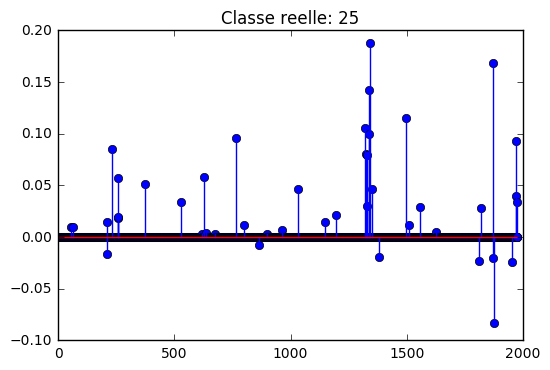

In [44]:
plt.figure()
plt.stem(x)
plt.title('Classe reelle: ' + str(ytest[testval]))

### Residuals

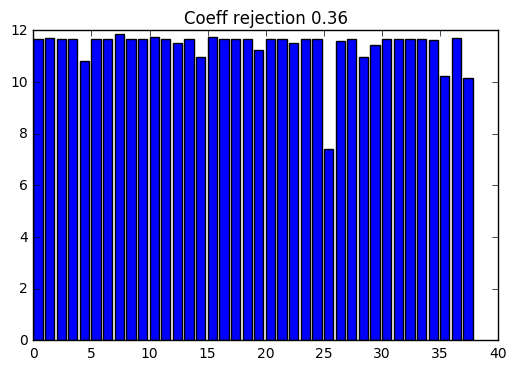

In [45]:
plt.figure()
plt.clf()
plt.bar(range(38),residu(Xtest[:,testval],Xtrain,x,ytrain))
plt.title('Coeff rejection ' + str(np.round(SCI(x,ytrain),2)))

### Image reconstruction

Here we get the original images and the coeff of selected image with the sparse representation and we reconstruct our image 

** Original **

In [46]:
i_original = indices_test[testval] #L'indice de la photo dans le dataset de départ non séparé

try:
    X_toconcat_original = [np.reshape(e,(X_original[0].shape[0]*X_original[0].shape[1],1)) for i,e in enumerate(X_original)]
except:
    print(e.shape)
    plt.imshow(X_original[i], cmap='gray')

# Puis concaténation pour avoir une matrice unique
Xoriginal = np.concatenate(X_toconcat_original,axis=1) # Liste des samples du train, concaténés en colonne.

** Error on image **

In [47]:
erreur_recomposition = np.reshape(np.dot(Xoriginal[:,indices_train],x),(X_original[i_original].shape[0],X_original[i_original].shape[1]))    

** Print recomposed image with just the predicted class **

In [48]:
# On recompose l'image en utilisant seulement les composantes du vecteur x liées à la classe prédite.
face_recomposee = np.reshape(np.dot(Xoriginal[:,indices_train],delta(x,pred_class,ytrain)),(X_original[i_original].shape[0],X_original[i_original].shape[1]))

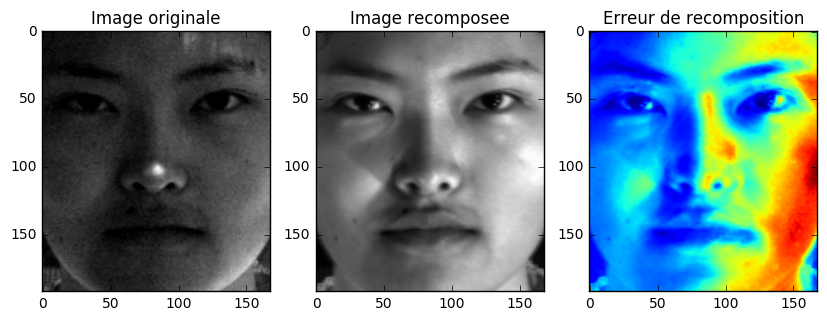

In [49]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[i_original], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(face_recomposee, cmap='gray')
plt.title('Image recomposee')
plt.subplot(1,3,3)
plt.imshow(erreur_recomposition)
plt.title('Erreur de recomposition')

# Algorithm 1 implementation of classification with noise

Here we will add noise to our test image and see if the classification is good or not